** Model to classify prompts for LLM Expert model selection
** Classify Types: 
** language, math, developer, content, and cyber

In [1]:
# import all supported libraries
# math libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D, MaxPooling1D, BatchNormalization, Activation, LeakyReLU, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
# manage warnings 
import warnings
warnings.filterwarnings('ignore', category=UserWarning) 

In [2]:
	
# check tensorflow version
print(tf.__version__)

# If a GPU is available, this should print a device name that includes "Metal"
print(tf.config.list_physical_devices('GPU'))

# verify tensorflow sees all GPUs available on my M1 Max
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
# read in json data file
df = pd.read_json("data/prompts.json")
print(df.shape)
df.head(40)

(77424, 4)


,instruction,input,output,label
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,language
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",language
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",language
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,language
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,language
5,Identify the odd one out.,"Twitter, Instagram, Telegram",Telegram,language
6,Explain why the following fraction is equivale...,4/16,The fraction 4/16 is equivalent to 1/4 because...,math
7,Write a short story in third person narration ...,,John was at a crossroads in his life. He had j...,language
8,Render a 3D model of a house,,<nooutput> This type of instruction cannot be ...,math
9,Evaluate this sentence for spelling and gramma...,He finnished his meal and left the resturant,He finished his meal and left the restaurant.,math


In [4]:
# drop columns input and output
df = df.drop(['input', 'output'], axis=1)
print(df.shape)

(77424, 2)


# Begin preprocessing

In [5]:
# calculate the number of unique labels in each column
unique_labels = df.apply(pd.Series.nunique)
print("NUMBER of unique labels in each column:")
print(unique_labels)
print("\n")

print("unique labels in labels column:")
# print the unique labels in labels column
print(df.label.unique())
print("\n")

print("number of label values counts:")
# print the number of label values in each column
print(df.label.value_counts())
print("\n")

NUMBER of unique labels in each column:
instruction    77406
label              3
dtype: int64


unique labels in labels column:
['language' 'math' 'code']


number of label values counts:
label
language    42228
code        22009
math        13187
Name: count, dtype: int64




In [6]:
# create a dataframe of length = 5000 based on the column label = code
categories = ['code', 'language', 'math']
df_dict = {}

for category in categories:
    df_dict[category] = df[df.label == category].head(13000)
    print(f'Shape of df_{category}: {df_dict[category].shape}')

Shape of df_code: (13000, 2)
Shape of df_language: (13000, 2)
Shape of df_math: (13000, 2)


In [7]:
# In this section we create all training, validate and test data 
# Concatenate the data from all categories
X = pd.concat([df_dict['code'], df_dict['language'], df_dict['math']])

In [8]:
# Assuming that 'target' is the name of the column containing the target variable
y = X['label']

# Split the data into training and testing sets (80% for training and 20% for testing)
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets (70% for training and 30% for validation)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train)

(21840, 2)
(21840,)
(9360, 2)
(9360,)
(7800, 2)
(7800,)
                                             instruction     label
59483  Adapt the following Java program to print the ...      code
2617                        Tell me a story with a moral  language
73923  A bird population is decreasing exponentially....      math
6504   Summarize the importance of Mahatma Gandhi's a...      math
54374  Combine these two CSS selectors using combinators      code
...                                                  ...       ...
15210                  Suggest a strategy to save money.  language
56532  Create a program that logs the time a user ent...      code
7032   Make a list of 5 sentence starters that use th...  language
53181  Construct an MySQL query to select records fro...      code
1073                 Define the term 'anthropomorphism'.  language

[21840 rows x 2 columns]


In [9]:
# Tokenize the input sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train['instruction'])

# Append tokenized sequences to the X_train dataframe as a new column
X_train['instruction_tokenized'] = tokenizer.texts_to_sequences(X_train['instruction'])
X_validate['instruction_tokenized'] = tokenizer.texts_to_sequences(X_validate['instruction'])
X_test['instruction_tokenized'] = tokenizer.texts_to_sequences(X_test['instruction'])

In [10]:
#print(X_train)

# Pad the sequences to a fixed length
max_len = 100
num_classes = 3
X_train_pad = pad_sequences(X_train['instruction_tokenized'], maxlen=max_len, padding='post', truncating='post')
X_validate_pad = pad_sequences(X_validate['instruction_tokenized'], maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test['instruction_tokenized'], maxlen=max_len, padding='post', truncating='post')

print(X_train_pad)

# Create a label encoder object
encoder = LabelEncoder()

# Fit the encoder on the training labels
encoder.fit(y_train)

# Convert the training, validation, and test labels to integers
y_train_int = encoder.transform(y_train)
y_validate_int = encoder.transform(y_validate)
y_test_int = encoder.transform(y_test)

# Convert the integer labels to one-hot encoding
num_classes = len(encoder.classes_)
y_train_onehot = to_categorical(y_train_int, num_classes)
y_validate_onehot = to_categorical(y_validate_int, num_classes)
y_test_onehot = to_categorical(y_test_int, num_classes)

[[2554    2   16 ...    0    0    0]
 [ 413  282    3 ...    0    0    0]
 [   3 1837  529 ...    0    0    0]
 ...
 [  97    3   22 ...    0    0    0]
 [ 104   11  533 ...    0    0    0]
 [ 495    2  253 ...    0    0    0]]


In [11]:
# Add helper methods to reset before every refresh of model building
def reset_model(model, optimizer):
    global history  
    model.reset_states()
    optimizer.reset_states()

    # reset tensorflow session
    tf.keras.backend.clear_session()

    # inititalize random seed
    np.random.seed(42)

    # Initialize the history object
    history = []
    return optimizer, model

# Create a Neural Network Model

In [12]:
reset_model = tf.keras.callbacks.LambdaCallback(on_epoch_end=reset_model)
# abandoned this model as the training and validation consistently underperformed even after hyperparameter tuning 
def cnn_model(num_classes, input_shape=(None,)):
    model = Sequential([
                # Embedding layer
        Embedding(input_dim=10000, output_dim=128, input_length=max_len),

        # First convolutional block
        Conv1D(32, 3, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Dropout(0.3),

        # Second convolutional block
        Conv1D(64, 3, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Dropout(0.4),

        # Third convolutional block
        Conv1D(128, 3, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Dropout(0.4),

        # Flattening the convolutional layer output
        Flatten(),
        #GlobalAveragePooling1D(),

        # Dense layers for classification
        Dense(128),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        # Output layer
        Dense(num_classes, activation='softmax')


    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model with the default input_shape and num_classes  
num_classes = 3  
max_len = 100
model = cnn_model(num_classes, max_len)
model.summary()

2024-04-02 11:51:51.379125: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-02 11:51:51.379151: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-02 11:51:51.379158: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-02 11:51:51.379195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-02 11:51:51.379211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           12320     
                                                                 
 batch_normalization (Batch  (None, 100, 32)           128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 32)            0

In [13]:
# set hyperparameters
batch_size = 64
epochs = 20
# Add early stopping to monitor the validation loss and stop training when it begins to increase
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 

# Now use the train_generator for training and validation_generator for validation directly
# Train the model
history = model.fit(
    X_train_pad, 
    y_train_onehot, 
    validation_data=(X_validate_pad, 
                     y_validate_onehot), 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     callbacks=[early_stopping])

Epoch 1/20


2024-04-02 11:51:52.487375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


342/342 [==============================] - 23s 62ms/step - loss: 0.5928 - accuracy: 0.7640 - val_loss: 2.1123 - val_accuracy: 0.3348
Epoch 2/20
342/342 [==============================] - 19s 57ms/step - loss: 0.2725 - accuracy: 0.9118 - val_loss: 0.4164 - val_accuracy: 0.8647
Epoch 3/20
342/342 [==============================] - 19s 56ms/step - loss: 0.2152 - accuracy: 0.9288 - val_loss: 0.2966 - val_accuracy: 0.9107
Epoch 4/20
342/342 [==============================] - 19s 56ms/step - loss: 0.1882 - accuracy: 0.9375 - val_loss: 0.3074 - val_accuracy: 0.9054
Epoch 5/20
342/342 [==============================] - 19s 56ms/step - loss: 0.1673 - accuracy: 0.9421 - val_loss: 0.3141 - val_accuracy: 0.9068
Epoch 6/20
342/342 [==============================] - 19s 56ms/step - loss: 0.1492 - accuracy: 0.9478 - val_loss: 0.3550 - val_accuracy: 0.8991
Epoch 7/20
342/342 [==============================] - 19s 56ms/step - loss: 0.1389 - accuracy: 0.9505 - val_loss: 0.3481 - val_accuracy: 0.9027
Epo

In [14]:
datasets = {
    'train': {'data': X_train_pad, 'labels': y_train_onehot},
    'test': {'data': X_test_pad, 'labels': y_test_onehot},
    'validation': {'data': X_validate_pad, 'labels': y_validate_onehot}
}

class_names = ['language','math','code']

In [15]:
# generalized wrapper function that test model performance 
def validate_model_performance(model, datasets, class_names):
    """
    Validates the model performance by plotting accuracy, making predictions,
    printing a classification report, and displaying a confusion matrix.

    Parameters:
    - model: The trained model.
    - datasets: A dictionary containing datasets. Each item should have 'data' and 'labels' keys.
                Example: {'train': {'data': X_train_normalized, 'labels': y_train_encoded},
                          'test': {'data': X_test_normalized, 'labels': y_test_encoded},
                          'validation': {'data': X_validation_normalized, 'labels': y_validation_encoded}}
    - class_names: List of class names for plotting the confusion matrix.
    """
    for dataset_name, dataset in datasets.items():
        print(f"Validating on {dataset_name} dataset")
        
        # Make predictions
        predictions = model.predict(dataset['data'])

        # Convert predictions from one-hot encoded vectors to class labels
        predicted_classes = np.argmax(predictions, axis=1)

        # Assuming the labels are also one-hot encoded, convert them back to labels
        if dataset['labels'].ndim > 1:  # Check if labels are one-hot encoded
            true_classes = np.argmax(dataset['labels'], axis=1)
        else:
            true_classes = dataset['labels']

        # Print classification report
        print(classification_report(true_classes, predicted_classes, target_names=class_names, zero_division=0))

        # Plot the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(confusion_matrix(true_classes, predicted_classes), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {dataset_name} Dataset')
        plt.ylabel('Actual labels')
        plt.xlabel('Predicted labels')
        plt.show()

Validating on train dataset
683/683 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

    language       0.94      0.94      0.94      7303
        math       0.92      0.99      0.96      7284
        code       0.97      0.89      0.93      7253

    accuracy                           0.94     21840
   macro avg       0.94      0.94      0.94     21840
weighted avg       0.94      0.94      0.94     21840



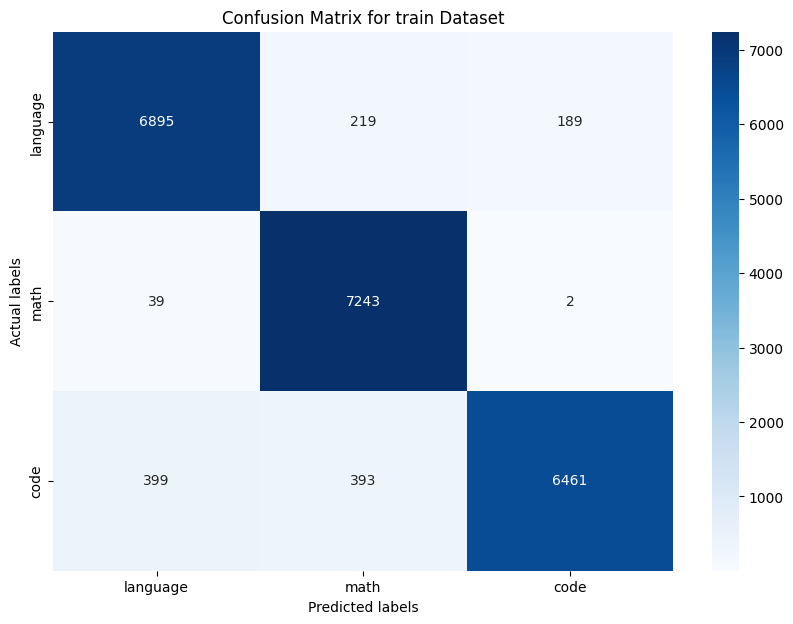

Validating on test dataset
244/244 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    language       0.91      0.90      0.91      2618
        math       0.86      0.98      0.91      2588
        code       0.95      0.83      0.89      2594

    accuracy                           0.90      7800
   macro avg       0.91      0.90      0.90      7800
weighted avg       0.91      0.90      0.90      7800



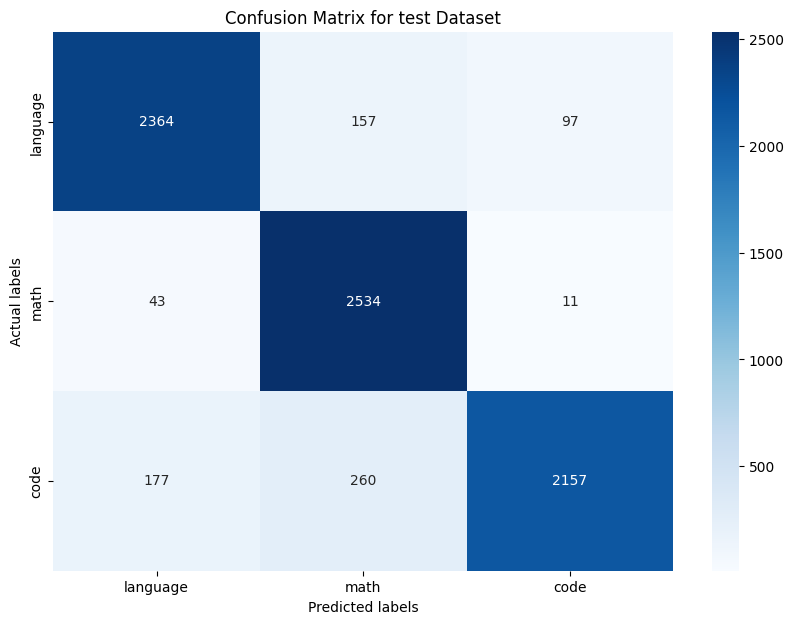

Validating on validation dataset
293/293 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    language       0.92      0.90      0.91      3079
        math       0.86      0.98      0.92      3128
        code       0.95      0.85      0.90      3153

    accuracy                           0.91      9360
   macro avg       0.91      0.91      0.91      9360
weighted avg       0.91      0.91      0.91      9360



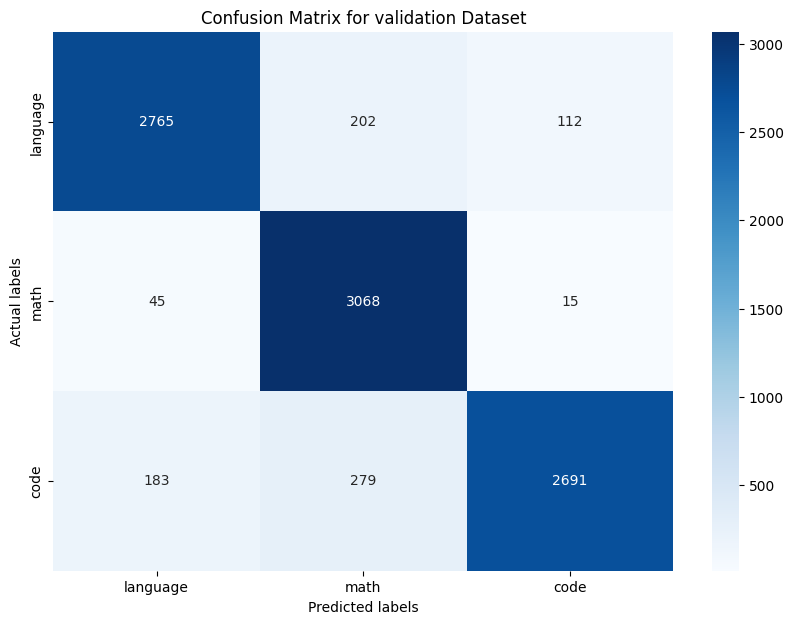

In [16]:
validate_model_performance(model, datasets, class_names)

In [17]:
model.save('model.h5')

In [18]:
from tensorflow.keras.models import load_model
model2 = load_model('model.h5')

In [19]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           12320     
                                                                 
 batch_normalization (Batch  (None, 100, 32)           128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 32)            0

# Inference

In [ ]:
# # read in json data file
# df = pd.read_json("data/prompts.json")
# print(df.shape)
# df.head(40)

In [21]:
sentence = "What is 2 + 2?"

In [22]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentence)

# Append tokenized sequences to the X_train dataframe as a new column
sentence = tokenizer.texts_to_sequences([sentence])
max_sentence_length = 100

padded_sequence = pad_sequences(sentence, maxlen=max_sentence_length, padding='post')


padded_sequence_array = np.array(padded_sequence)

prediction = model2.predict(padded_sequence_array)

print(prediction)

1/1 [==============================] - 1s 1s/step
[[0.00378412 0.9901932  0.00602269]]


** from this point we need to create a rest api to publish the model and get the predictions **